In [5]:
import numpy as np
from scipy.special import logsumexp
import scipy.stats as sps
import matplotlib.pyplot as plt

In [6]:
class IBP_Graded:
    """
    Uncollapsed Gibbs sampler for infinite sparse factor analysis model
    """
    def __init__(self, alpha, sigma_n, sigma_a, sigma_y, K_trunc):
        self.alpha = alpha
        self.sigma_a = sigma_a
        self.sigma_n = sigma_n
        self.sigma_y = sigma_y

        self.K_trunc = K_trunc

        self.data = None

    def init_Z(self):
        K_init = 1
        # K_init = self.K_trunc

        Z = np.zeros((self.N, K_init))
        for i in range(self.N):
            Z[i] = np.random.choice(2)
        return Z

    def init_A(self, K):
        return np.stack([np.random.multivariate_normal(np.zeros(K),
            self.sigma_a * np.eye(K)) for _ in range(self.D)]).T

    def init_Y(self, K):
        return np.stack([np.random.multivariate_normal(np.zeros(K), 
            self.sigma_a * np.eye(K)) for _ in range(self.N)])

    def z_new_col_prior(self, k):
        # p(z_{i,k new} = 1 | Z_{-i, k})
        return sps.poisson(self.alpha / self.N).logpmf(k)

    def Z_prior(self, Z):
        # P(Z)
        lp = 0
        K = Z.shape[1]

        lp += K * np.log(self.alpha)

        sampled_dishes = 0

        counter = 0
        while sampled_dishes != K:
            counter += 1
            for k in range(K, sampled_dishes, -1):
                idx = np.where(Z[:, sampled_dishes:k] == np.ones(k))
                if idx is not None:
                    lp -= gammaln(k + 1)
                    sampled_dishes = k
                    break

            if counter > K:
                raise Exception("Z prior computation failed!")

        # asymptotic estimate of the nth harmonic number:
        # H_n = log(n) + gamma + 1/2n - 1/12n^2 + 1/120n^4 + O(1/n^6)
        gamma = 0.57721566490153286060651209008240243104215933593992
        Hn = gamma + np.log(self.N) + 0.5 / self.N - 1. / (12 * self.N ** 2) \
                + 1./(120 * self.N ** 4)

        lp -= self.alpha * Hn

        for k in range(K):
            z_sum = Z[:, k].sum()
            lp += gammaln(self.N - z_sum + 1) + gammaln(z_sum)
            lp -= gammaln(self.N + 1)

        return lp

    def A_prior(self, A):
        # P(A)
        lp = 0
        K = A.shape[0]

        lp -= self.D / 2 * np.log(2 * np.pi * self.sigma_a)
        lp -= 1 / (2 * self.sigma_a) * np.trace(np.dot(
            A.T,
            A
            ))

        return lp

    def Y_prior(self, Y):
        lp = 0
        K = Y.shape[1]

        lp = -self.K / 2 * np.log(2 * np.pi * self.sigma_y)
        lp -= 1 / (2 * self.sigma_y) * np.trace(np.dot(
            Y, Y.T
            ))

        return lp

    def log_lik_i(self, Z, A, Y, i):
        # p(X_i | Z, A)
        # if only Z_i changes, then only p(X_i | Z, A) changes
        lp = -self.likelihood_constant

        pred_mean = np.dot(Z[i] * Y[i], A)
        lp -= 1 / (2 * self.sigma_n) * np.dot(
                (self.data[i] - pred_mean).T,
                self.data[i] - pred_mean
                )

        return lp

    def log_lik(self, Z, A, Y):
        # p(X | Z, A)
        lp = - self.N * self.likelihood_constant

        pred_mean = np.dot(Z * Y, A)
        lp -= 1 / (2 * self.sigma_n) * np.trace(np.dot(
                (self.data - pred_mean).T,
                self.data - pred_mean
                ))

        return lp

    def log_joint(self, Z, Y, A):
        # P(Z, X, A)
        return self.Z_prior(Z) + self.A_prior(A) + self.log_lik(Z, A, Y)

    def sample_A(self, Z, Y):
        K = Z.shape[1]
        
        factors = Z * Y
        inv_mat = np.linalg.inv(
                np.dot(factors.T, factors) + (self.sigma_n / self.sigma_a) * np.eye(K)
                )
        mu = np.dot(inv_mat,
                np.dot(factors.T, self.data))
        # cov = self.sigma_n * inv_mat

        # return np.stack([np.random.multivariate_normal(mu_i, cov) for
        #     mu_i in mu.T]).T
        return mu

    def sample_Y_i(self, Z, A, Y, i):
        Y_new = Y.copy()
        K = Z.shape[1]

        loadings = Z[i, :, None] * A
        inv_mat = np.linalg.inv(
                np.dot(loadings, loadings.T) + \
                        (self.sigma_n / self.sigma_y) * np.eye(K)
                        )
        mu = np.dot(inv_mat, np.dot(
            loadings, self.data[i].T))
        # cov = self.sigma_n * inv_mat
        # Y_new[i] = np.random.multivariate_normal(mu, cov)
        Y_new[i] = mu

        return Y_new

    def sample_new_columns(self, Z, A, Y, i, lp_no_col):
        # propose adding new columns
        K = Z.shape[0]
        lp_new_col = np.zeros(self.K_trunc)
        lp_new_col[0] = lp_no_col + self.z_new_col_prior(0)

        new_col = np.zeros((self.N, self.K_trunc))
        new_col[i] = 1

        new_features = self.init_A(self.K_trunc)
        new_factors = self.init_Y(self.K_trunc)

        for k in range(1, self.K_trunc):
            Z_tmp = np.concatenate((Z, new_col[:, :k]), axis=1)
            A_tmp = np.concatenate((A, new_features[:k, :]), axis=0)
            Y_tmp = np.concatenate((Y, new_factors[:, :k]), axis=1)

            lp_new_col[k] = self.log_lik(Z_tmp, A_tmp, Y_tmp) + self.z_new_col_prior(k)

        lp_new_col = lp_new_col - logsumexp(lp_new_col)
        k_new = np.random.choice(self.K_trunc, p = np.exp(lp_new_col))

        if k_new == 0:
            return Z, A, Y
        else:
            return (Z_tmp[:K + k_new], A_tmp[:K + k_new, :], 
                    Y_tmp[:, :K + k_new])

    def sample_Z_ik(self, Z, A, Y, i, k, lp):
        z_sum = Z[:, k].sum() - Z[i, k]
        lp_no_i = lp - self.log_lik_i(Z, A, Y, i)

        Z[i, k] = 0
        lprior_0 = np.log(self.N - z_sum) - np.log(self.N)
        lp_0 = lp_no_i + self.log_lik_i(Z, A, Y, i)

        Z[i, k] = 1
        lprior_1 = np.log(z_sum) - np.log(self.N)
        lp_1 = lp_no_i + self.log_lik_i(Z, A, Y, i)

        accept_prob = lp_1 + lprior_1 - \
                np.logaddexp(lp_1 + lprior_1, lp_0 + lprior_0) 

        if np.log(np.random.uniform()) <= accept_prob:
            return 1, lp_1
        else:
            return 0, lp_0

    def sample(self, Z_prev, A_prev, Y_prev):
        Z = Z_prev.copy()
        A = A_prev.copy()
        Y = Y_prev.copy()
        lp = 0

        for i in range(Z.shape[0]):
            lp = self.log_lik(Z, A, Y)
            for k in range(Z.shape[1]):
                if (Z[:, k].sum() - Z[i, k]) == 0:
                    lp -= self.log_lik_i(Z, A, Y, i)
                    Z[i, k] = 0
                    lp += self.log_lik_i(Z, A, Y, i)
                else:
                    Z[i, k], lp = self.sample_Z_ik(Z, A, Y, i, k, lp)

            nonempty = np.where(Z.sum(axis=0) != 0)[0]

            Z = Z[:, nonempty]
            A = A[nonempty, :]
            Y = Y[:, nonempty]

            # sample new columns
            Z, A, Y = self.sample_new_columns(Z, A, Y, i, lp)

            Y = self.sample_Y_i(Z, A, Y, i)
            A = self.sample_A(Z, Y)

        return Z, A, Y

    def observe(self, data):
        self.data = data
        self.N, self.D = data.shape

        self.likelihood_constant = self.D / 2 * \
                np.log(2 * np.pi * self.sigma_n)

    def infer(self, data, burn=10, n_iter=25):
        if self.data is None:
            self.observe(data)

        Z = self.init_Z()
        A = self.init_A(Z.shape[1])
        Y = self.init_Y(Z.shape[1])

        for i in range(burn):
            if i % 5 == 0:
                self.full_rank_update = True
            print("iteration ", i)
            Z, A, Y = self.sample(Z, A, Y)
            print(self.log_lik(Z, A, Y))
            # print(Z.shape[1])
            # print(np.sum((np.dot(Z * Y, A) - self.data) ** 2))

        #breakpoint()
        print("=======================sampling==================")

        map_estimate = (Z, A, Y)
        lp = -np.inf
        for i in range(n_iter):
            print(i)
            Z, A, Y = self.sample(Z, A, Y)
            lp_new = self.log_lik(Z, A, Y)

            if lp_new > lp:
                map_estimate = (Z, A, Y)
                lp = lp_new

        return map_estimate, lp

(-0.008964179375648614, 1.028907211115212)

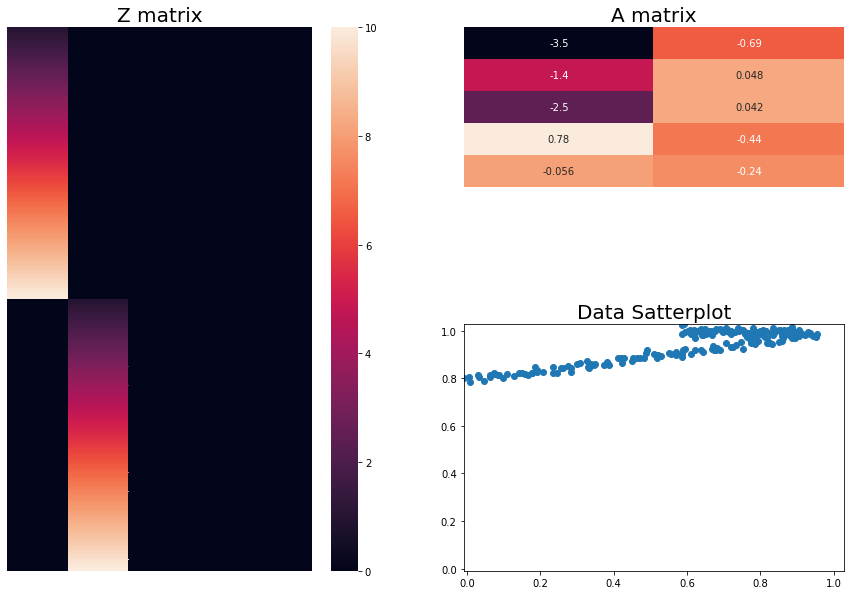

In [7]:
# Ground truth definition
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from datetime import datetime
now = datetime.now


gK = 5 # How many factors (not all have ot active)
D = 2 # Dimensionality of the data
N = 200 # N datapoints

Z = np.zeros((N,gK)) # pre-allocate Z matrix

case = 4

if case==1: #One factor
    Z[:,0]=1
    #Z[int(N/2):-1,0]=1
elif case==2: #Two ofactors
    #Z[::2,0]=1
    Z[:,0]=1
    Z[1::2,1]=1
elif case==3: # Three factors
    Z[0::3,0]=1
    Z[1::3,1]=1
    Z[2::3,2]=1
elif case==4: # Two factors graded
    #Z[:,0]=1
    #Z[:,1]=1
    Z[0:int(N/2),0] = np.linspace(1.,10,int(N/2))
    Z[int(N/2):,1] = np.linspace(1.,10,int(N/2))
    #Z[0:int(N/2),0] = 1
    #Z[int(N/2):,1] = 1
    #Z[int(N*.3):int(N*2/3):,2] = 1

# Plot Z matrix    
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.heatmap(Z,annot=False)
plt.title('Z matrix',fontsize=20)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);

# Sample an A matrix
cov = np.eye(D);
A = mvnorm(mean=np.zeros(D), cov=cov).rvs(gK)
#A = np.array(([ 0.37880717,  1.29126631],[ 0.94770151,  0.07006182],[-0.42720817,  1.09532847]))

# Plot A
plt.subplot(3,2,2)
sns.heatmap(A,annot=True,cbar=False)
plt.title('A matrix',fontsize=20)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);

# Data 
data = np.matmul(Z,A) # Data is Z*A
e = np.random.randn(data.shape[0],data.shape[1])*0.01 # Some error

# Normalise data?
#data = data / data.sum(axis=0) #Normalise
data = data-data.min()
data /= data.max() #Normalise
#data *= 100 # Scale
data = data+e # Add error
#data *= 10

plt.subplot(2,2,4)
plt.scatter(data[:,0],data[:,1])
plt.title('Data Satterplot',fontsize=20)
plt.xlim((data.min(),data.max()))
plt.ylim((data.min(),data.max()))

#plt.tight_layout()

In [8]:
model = IBP_Graded(alpha=1, sigma_n=1, sigma_a=1, sigma_y=1, K_trunc=5)
model.observe(data)
map_estimate, lp = model.infer(data,burn=20, n_iter=100)
print('done')

iteration  0
-490.77757385145037
iteration  1
-447.49856060213307
iteration  2
-438.65154424609517
iteration  3
-422.5621463493492
iteration  4
-401.8560727014452
iteration  5
-393.3539281475937
iteration  6
-381.1025039833822
iteration  7
-373.147008783861
iteration  8
-372.3827731991225
iteration  9
-372.7334870678505
iteration  10
-371.69126126367286
iteration  11
-371.7651129971788
iteration  12
-371.425366709017
iteration  13
-374.6215080347154
iteration  14
-374.20206403627554
iteration  15
-371.0537918159029
iteration  16
-370.8060049027153
iteration  17
-370.77970280561453
iteration  18
-372.1971184332839
iteration  19
-371.77332785391104
=======================sampling==================
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done


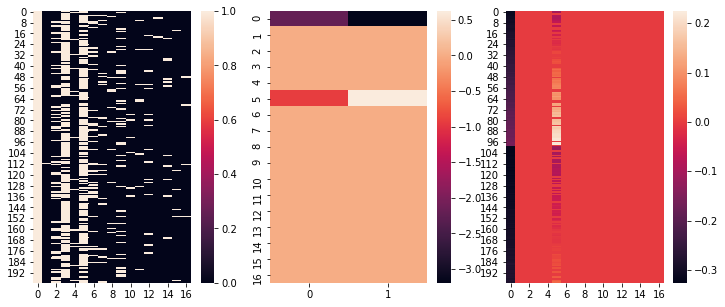

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.heatmap(map_estimate[0])

plt.subplot(1,3,2)
sns.heatmap(map_estimate[1])

plt.subplot(1,3,3)
sns.heatmap(map_estimate[2])